### HyperFace: A Deep Multi-task Learning Framework for Face Detection, Landmark Localization, Pose Estimation, and Gender Recognition

https://arxiv.org/pdf/1603.01249.pdf

- CNN architecture for face detection, landmark localization, pose estimation and gender classification simultaneously (boosting the performance of individual tasks [58] , [57], [5]). The network architecture is deep in both vertical and horizontal direction. Based on Alexnet.
- Post-processing methods: iterative region proposals and landmarks-based non-maximum suppression
- overall time taken to perform all the four tasks was 3s per image
- face related tasks benefit from using the multitask learning framework.
- **Lower layers respond to edges and corners, and hence contain better localization properties. They are more suitable for learning landmark localization and pose estimation tasks.** Higher layers are class-specific and suitable for learning complex tasks such as face detection and gender recognition (detection and classification) [53]. We refer the set of intermediate layer features as hyperfeatures. [1]
- Since the adjacent layers are highly correlated, we do not consider all the intermediate layers for fusion.
- Features fusion aims to transform the features to a common subspace where they can be combined linearly or non-linearly: fusion-CNN to fuse the hyperfeatures
- We did not include any pooling operation in the fusion network as it provides local invariance which is not desired for the face landmark localization task.
- HyperFace consists of three modules.
    - The first one generates class independent region-proposals from the given image and scales them to 227 × 227 pixels.
    - The second module is a CNN which takes in the resized candidate regions and classifies them as face or non-face. If a region gets classified as a face, the network additionally provides facial landmarks locations, estimated head pose and gender information.
    - The third module is a post-processing step which involves iterative region propos- als and landmarks-based non-maximum suppression (NMS) to boost the face detection score and improve the perfor- mance of individual tasks.
- Datasets
    - Annotated Face in-the-Wild (AFW) [57] for evaluating face detection, landmark localization, and pose estima- tion tasks
    - Annotated Facial Landmarks in the Wild (AFLW) [22] for evaluating landmark localization and pose estima- tion tasks
    - Face Detection Dataset and Benchmark (FDDB) [18] and PASCAL faces [48] for evaluating the face detection results
    - Large-scale CelebFaces Attributes (CelebA) [31] and LFWA [17] for evaluating gender recognition results.
- Selective Search [43] algorithm in RCNN [12]

### Usando SqueezeNet en HyperFace

Seeing that Hyperface with VGG16 as main model is so big, we decide to try to train in a 'smaller' architecture (SqueezeNet https://arxiv.org/abs/1602.07360v3).

Reducing the size of AlexNet:
- SVD: 5x compression, 56% top-1 accuracy
- Pruning: 9x compression, 57.2% top-1 accuracy
- Deep Compression: 35x compression, ~57% top-1 accuracy
- SqueezeNet: 50x compression, ~57% top-1 accuracy

Total params: 5,858,150

In [1]:
from keras import backend as K
from keras.models import Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D, merge
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop, SGD
import keras.backend as kb
import keras.losses as losses
import tensorflow as tf
import os
import time
import numpy as np
import h5py
import squeeze
import hf

Using TensorFlow backend.


#### 1. Replicando la arquitectura del modelo

- La red ya tiene pesos entrenados.
- Obviamos la capa de clasificación de Squeeze.
- ¿Cómo hacer fine-tuning?

<!-- <img src="squeezenet-architecture.png"/> -->

In [2]:
model = squeeze.SqueezeNet()
model = Model(inputs=model.input, outputs=model.get_layer('drop9').output)
# model.summary()

**Principales diferencias con el paper original**
- Se usa una profundidad de 128 en vez de 256, por lo que la Combinación es de 384 en vez de 768
- Para las "hypercaracterísticas" se usan las capas que más se asemejan a las del paper original:
    - Para 1er grupo se usa "pool3" 27x27x128 a diferencia de 27x27x96
    - Para 2do grupo se usa "pool5" 13x13x256 a diferencia de 13x13x384
    - Para 3er grupo se usa "drop9" 13x13x512 a diferencia de 6x6x256
- Para la Reducción se usa 6x6x96 en vez de 6x6x192 (al parecer hay un error en el paper)

<img src="HyperFace-architecture.small.png"/>

In [3]:
#
# Hypercaracterísticas
#

# 1er grupo de hypercaracterísticas: "conv1a" - se asume usar kernel y strides adecuados
conv1a_input = model.get_layer('pool3').output
#6x6
conv1a = Convolution2D(128, (4,4), strides=(4,4), activation='relu', padding='valid', name='conv1a')(conv1a_input)
#4x4
#conv1a = Convolution2D(128, (6,6), strides=(6,6), activation='relu', padding='valid', name='conv1a')(conv1a_input)
print("hypercaracterísticas #1 - in:", conv1a_input.shape, 'out:', conv1a.shape)

# 2do grupo de hypercaracterísticas: "conv3a"
conv3a_input = model.get_layer('pool5').output
#6x6
conv3a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
#4x4
#conv3a = Convolution2D(128, (3,3), strides=(3,3), activation='relu', padding='valid', name='conv3a')(conv3a_input)
print("hypercaracterísticas #2 - in:", conv3a_input.shape, 'out:', conv3a.shape)

# 3er grupo de hypercaracterísticas: "conv5a"
conv5a_input = model.get_layer('drop9').output
#6x6
conv5a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv5a')(conv5a_input)
#4x4
#conv5a = Convolution2D(128, (3,3), strides=(3,3), activation='relu', padding='valid', name='conv5a')(conv5a_input)
print("hypercaracterísticas #3 - in:", conv5a_input.shape, 'out:', conv5a.shape)

# Combinación: 6x6x384
concat = concatenate([conv1a, conv3a, conv5a], axis=-1, name='concat')
print("combinación:", concat.shape)

# Reducción de dimensión: 6x6x96
conv_all = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding='valid', name='conv_all')(concat)
print("reducción:", conv_all.shape)

# completamente conectadas
fc_full = Flatten(input_shape=conv_all.shape, name='fc_full')(conv_all)
# print(fc_full.shape)

#
# Cabezas de clasificación
#

# rostro/no rostro
fc_detecton = Dense(256, name='fc_detecton', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
face_nonface = Dense(2, name='face_nonface', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_detecton)
print("rostro/no rostro - in:", fc_detecton.shape, "out:", face_nonface.shape)

# puntos característicos
fc_landmarks = Dense(256, name='fc_landmarks', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
landmarks = Dense(42, name='landmarks', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_landmarks)
print("puntos característicos - in:", fc_landmarks.shape, "out:", landmarks.shape)

# visibilidad
fc_visibility = Dense(256, name='fc_visibility', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
visibility = Dense(21, name='visibility', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_visibility)
print("visibilidad - in:", fc_visibility.shape, "out:", visibility.shape)

# pose
fc_pose = Dense(256, name='fc_pose', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
roll_pitch_yaw = Dense(3, name='roll_pitch_yaw', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_pose)
print("pose - in:", fc_pose.shape, "out:", roll_pitch_yaw.shape)

# género
fc_gender = Dense(256, name='fc_gender', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
male_female = Dense(3, name='male_female', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_gender)
print("género - in:", fc_gender.shape, "out:", male_female.shape)

hypercaracterísticas #1 - in: (?, 27, 27, 128) out: (?, 6, 6, 128)
hypercaracterísticas #2 - in: (?, 13, 13, 256) out: (?, 6, 6, 128)
hypercaracterísticas #3 - in: (?, 13, 13, 512) out: (?, 6, 6, 128)
combinación: (?, 6, 6, 384)
reducción: (?, 6, 6, 96)
rostro/no rostro - in: (?, 256) out: (?, 2)
puntos característicos - in: (?, 256) out: (?, 42)
visibilidad - in: (?, 256) out: (?, 21)
pose - in: (?, 256) out: (?, 3)
género - in: (?, 256) out: (?, 3)


In [4]:
hyperface = Model(inputs=model.input, outputs=[face_nonface, landmarks, visibility, roll_pitch_yaw, male_female])
# hyperface.summary()

#### 2. Definiendo las funciones de pérdida y el algoritmo de aprendizaje
- Algunas versiones de Keras verifican que _y_ predecido y _y_ real tengan las mismas dimensiones, en Hyperface el cálculo de error de los landmarks toma en cuenta la visibilidad.
- Se ignora la visibilidad en el cálculo de la pérdida para los landmarks

The loss functions for the five networks are:
- Detection: BCE (binary cross-entropy). Detected bounding boxes that have an overlap >=0.5 with an annotated face are considered positive samples, bounding boxes with overlap <0.35 are considered negative samples, everything in between is ignored.
- Landmark localization: Roughly MSE (mean squared error), with some weighting for visibility. Only bounding boxes with overlap >0.35 are considered. Coordinates are normalized with respect to the bounding boxes center, width and height.
- Landmark visibility: MSE (predicted visibility factor vs. expected visibility factor). Only for bounding boxes with overlap >0.35.
- Pose estimation: MSE.
- Gender estimation: BCE.

In [5]:
def custom_loss_visibility(y_true, y_pred):
    # en paper: loss = 1/N * sum((vpredi-vi)^2)
    # para entrenar:
    return (1/21) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/21) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_pose(y_true, y_pred):
    # en paper: loss = 1/3 * sum((ppredi-pi)^2)
    # para entrenamiento:
    return (1/3) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/3) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_landmarks(coord_true, coord_pred):    
    # en paper: loss = 1/(2N) * Sum(vi*((xpredi-ai)^2 + (ypredi-bi)^2))
    x_true_coord = coord_true[:,0:21]
    y_true_coord = coord_true[:,21:42]
    # viz_true = coord_true[:,42:63]  # produce errores en otros entornos (versión de keras?)
    x_pred_coord = coord_pred[:,0:21]
    y_pred_coord = coord_pred[:,21:42]
    # para entrenamiento:
    # return (1/(2*21)) * kb.sum(viz_true * (kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    return (1/(2*21)) * kb.sum((kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    # para debug:
    # return (1/(2*21)) * np.sum(viz_true * ((x_pred_coord-x_true_coord)**2 + (y_pred_coord - y_true_coord)**2), axis=-1)

def custom_mse_lm(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*kb.sum(kb.square(tf.multiply((kb.sign(y_true)+1)*0.5, y_true-y_pred)),axis=-1)/kb.sum((kb.sign(y_true)+1)*0.5,axis=-1)

#optimizer = Adam(lr=0.0003)  # 0.003 NO # 0.01 NO # 0.001 # 0.0001
optimizer = SGD(lr=0.00001, momentum=0.9)  # SGD(lr=0.001, momentum=0.9)  # SGD(lr=1e-4, momentum=0.9) # mínimo 

hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'landmarks': custom_loss_landmarks,
                      'visibility': custom_loss_visibility,
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,  # 'face_nonface': 1,
                      'landmarks': 1,  # 'landmarks': 100,
                      'visibility': 1,  # 'visibility': 20,
                      'roll_pitch_yaw': 1,  # 'roll_pitch_yaw': 5,
                      'male_female': 1  # 'male_female': 0.3
                  },
                 metrics=['accuracy'])

print("Modelo compilado")

Modelo compilado


#### 3. Preparando conjunto de datos de entrenamiento y de validación
Corregir imágenes JPGs no válidas usando ImageMagick:
- `convert -resize 50% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg`
- `convert -resize 200% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg`

- /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/0/image22551.jpg
- /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/0/image23622.jpg
- /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/2/image09437.jpg
- /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/0/image21176.jpg


Como paso previo para la generación de los conjuntos de datos, se debe generar regiones usando el algoritmo Selective Search, luego de aplicado este proceso tenemos:

- Archivos de Entrenamiento:
    - Positivos: 12116
    - Negativos: 454512
- Archivos de Prueba
    - Positivos: 505
    - Negativos: 18938


In [10]:
print("Iterables para el conjunto de entrenamiento y validación")

json_dir = os.path.dirname(os.path.realpath('__file__'))  # genérico
batch_size = 30

#
# Conjunto de entrenamiento
# 

# real
trn_pos_json_file = 'positives5k-train.json'
trn_pos_count = 2000  # 12116
trn_pos_batch = batch_size
trn_neg_json_file = 'negatives5k-train.json'
trn_neg_count = 2000*3  # 12116*3
trn_neg_batch = batch_size*3
# prueba
#trn_pos_json_file, trn_pos_count, trn_pos_batch = 'positives.json', 2, 2
#trn_neg_json_file, trn_neg_count, trn_neg_batch = 'negatives.json', 2, 2

# iterable
train_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,                                                 
                                                 trn_pos_json_file, trn_neg_json_file, 
                                                 pos_max_load_labels=trn_pos_count, neg_max_load_labels=trn_neg_count, 
                                                 pos_batch_size=trn_pos_batch, neg_batch_size=trn_neg_batch,
                                                 output_type='hyperface', target_size=(227, 227))

#
# Conjunto de validación
#

# real
val_pos_json_file = 'positives5k-test.json'
val_pos_count = 100  # 505
val_pos_batch = batch_size
val_neg_json_file = 'negatives5k-test.json'
val_neg_count = 0 # 100*3  # 505*3
val_neg_batch = batch_size*3
# prueba
#val_pos_json_file, val_pos_count, val_pos_batch = 'positives.json', 2, 2
#val_neg_json_file, val_neg_count, val_neg_batch = 'negatives.json', 2, 2

# iterable
val_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
val_data_flow = val_data.flow_from_directory(json_dir, 
                                             val_pos_json_file, val_neg_json_file, 
                                             pos_max_load_labels=val_pos_count, neg_max_load_labels=val_neg_count, 
                                             pos_batch_size=val_pos_batch, neg_batch_size=val_neg_batch,
                                             output_type='hyperface', target_size=(227, 227))


Iterables para el conjunto de entrenamiento y validación
Found 2000 positive samples and 6000 negative samples.
Found 100 positive samples and 0 negative samples.


#### 4. Ejecutando entrenamiento

In [7]:
# # checkpoint
# filepath="weights-{epoch:02d}-{loss:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, mode='min', period=30)
# callbacks_list = [checkpoint]
# history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=300, callbacks=callbacks_list)

epochs = 5
steps_per_epoch = trn_pos_count//trn_pos_batch  # 403 para data de entrenamiento
val_steps = val_pos_count//val_pos_batch  # 16 para data de validación

model_yaml_file = 'hyperface.squeeze.model.yaml'
model_weights_file = 'hyperface.squeeze.weights.h5'
history_file = 'hyperface.squeeze.history.pkl'

print("Entrenamiento: epochs:", epochs,"steps per epoch:", steps_per_epoch, "validations steps:", val_steps)
history = hyperface.fit_generator(generator=train_data_flow,                                  
                                  steps_per_epoch=steps_per_epoch, 
                                  validation_data=val_data_flow,
                                  validation_steps=val_steps,
                                  epochs=epochs) 
print()

# guardando modelo
hyperface.save_weights(model_weights_file)
model_yaml = hyperface.to_yaml()
with open(model_yaml_file, 'w') as yaml_file:
    yaml_file.write(model_yaml)
print('Modelo y pesos escritos en disco')

# guardando history    
import pickle
with open(history_file, 'wb') as pkl_file:
    pickle.dump(history.history, pkl_file)

Entrenamiento: epochs: 5 steps per epoch: 66 validations steps: 3
Epoch 1/5
13/66 [====>.........................] - ETA: 129s - loss: 9.4428 - face_nonface_loss: 0.8794 - landmarks_loss: 4.7085 - visibility_loss: 0.3830 - roll_pitch_yaw_loss: 3.1490 - male_female_loss: 0.3229 - face_nonface_acc: 0.5929 - landmarks_acc: 0.0064 - visibility_acc: 0.0064 - roll_pitch_yaw_acc: 0.2750 - male_female_acc: 0.7359

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


27/66 [===========>..................] - ETA: 94s - loss: 6.8110 - face_nonface_loss: 0.7639 - landmarks_loss: 3.1986 - visibility_loss: 0.3689 - roll_pitch_yaw_loss: 2.2021 - male_female_loss: 0.2776 - face_nonface_acc: 0.6744 - landmarks_acc: 0.0080 - visibility_acc: 0.0105 - roll_pitch_yaw_acc: 0.3296 - male_female_acc: 0.6948

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


59/66 [=========================>....] - ETA: 16s - loss: 4.5690 - face_nonface_loss: 0.6778 - landmarks_loss: 1.9536 - visibility_loss: 0.3487 - roll_pitch_yaw_loss: 1.3618 - male_female_loss: 0.2270 - face_nonface_acc: 0.7150 - landmarks_acc: 0.0072 - visibility_acc: 0.0127 - roll_pitch_yaw_acc: 0.3114 - male_female_acc: 0.5939

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


66/66 [==============================] - 163s - loss: 4.3357 - face_nonface_loss: 0.6730 - landmarks_loss: 1.8219 - visibility_loss: 0.3458 - roll_pitch_yaw_loss: 1.2733 - male_female_loss: 0.2218 - face_nonface_acc: 0.7159 - landmarks_acc: 0.0071 - visibility_acc: 0.0134 - roll_pitch_yaw_acc: 0.3133 - male_female_acc: 0.5792 - val_loss: 1.5391 - val_face_nonface_loss: 0.5302 - val_landmarks_loss: 0.3374 - val_visibility_loss: 0.2953 - val_roll_pitch_yaw_loss: 0.2339 - val_male_female_loss: 0.1422 - val_face_nonface_acc: 0.7500 - val_landmarks_acc: 0.0028 - val_visibility_acc: 0.0083 - val_roll_pitch_yaw_acc: 0.3639 - val_male_female_acc: 0.3417
Epoch 2/5
66/66 [==============================] - 154s - loss: 1.9934 - face_nonface_loss: 0.5663 - landmarks_loss: 0.5490 - visibility_loss: 0.3086 - roll_pitch_yaw_loss: 0.4054 - male_female_loss: 0.1641 - face_nonface_acc: 0.7568 - landmarks_acc: 0.0090 - visibility_acc: 0.0153 - roll_pitch_yaw_acc: 0.3330 - male_female_acc: 0.3834 - val_lo

# Modelo sin visibilidad y puntos característicos

In [5]:
def custom_loss_pose(y_true, y_pred):
    return (1/3) * kb.sum(kb.square(y_pred-y_true), axis=-1)

fpg_hyperface = Model(inputs=model.input, 
                      outputs=[
                          face_nonface, 
                          # roll_pitch_yaw,
                          male_female])

# optimizer = Adam(lr=0.001)
optimizer = SGD(lr=0.0003, momentum=0.9)
fpg_hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      #'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      #'roll_pitch_yaw': 3,
                      'male_female': 1},
                 metrics=['accuracy'])

json_dir = os.path.dirname(os.path.realpath('__file__'))  # genérico
batch_size = 30

# Conjunto de entrenamiento
trn_pos_json_file = 'positives5k-train.json'
trn_pos_count = 1000 #2000 #12116
trn_pos_batch = batch_size
trn_neg_json_file = 'negatives5k-train.json'
trn_neg_count = 1000*3 #2000*3 #12116*3
trn_neg_batch = batch_size*3
fpg_train_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
fpg_train_data_flow = fpg_train_data.flow_from_directory(json_dir,                                                 
                                                 trn_pos_json_file, trn_neg_json_file, 
                                                 pos_max_load_labels=trn_pos_count, neg_max_load_labels=trn_neg_count, 
                                                 pos_batch_size=trn_pos_batch, neg_batch_size=trn_neg_batch,
                                                 # output_type='faceposegender', target_size=(227, 227)) 
                                                 output_type='facegender', target_size=(227, 227)) 
# Conjunto de validación
val_pos_json_file = 'positives5k-test.json'
val_pos_count = 100  # 505
val_pos_batch = batch_size
val_neg_json_file = 'negatives5k-test.json'
val_neg_count = 100*3  # 505*3
val_neg_batch = batch_size*3
fpg_val_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
fpg_val_data_flow = fpg_val_data.flow_from_directory(json_dir, 
                                             val_pos_json_file, val_neg_json_file, 
                                             pos_max_load_labels=val_pos_count, neg_max_load_labels=val_neg_count, 
                                             pos_batch_size=val_pos_batch, neg_batch_size=val_neg_batch,
                                             # output_type='faceposegender', target_size=(227, 227))
                                             output_type='facegender', target_size=(227, 227))
#
epochs = 10
steps_per_epoch = trn_pos_count//trn_pos_batch
val_steps = val_pos_count//val_pos_batch
model_yaml_file = 'hyperface.squeeze.model.yaml'
model_weights_file = 'hyperface.squeeze.weights.h5'
history_file = 'hyperface.squeeze.history.pkl'
# training
history = fpg_hyperface.fit_generator(generator=fpg_train_data_flow,                                  
                                  steps_per_epoch=steps_per_epoch, 
                                  validation_data=fpg_val_data_flow,
                                  validation_steps=val_steps,
                                  epochs=epochs) 

# guardando modelo
hyperface.save_weights(model_weights_file)
model_yaml = hyperface.to_yaml()
with open(model_yaml_file, 'w') as yaml_file:
    yaml_file.write(model_yaml)
print('Modelo y pesos escritos en disco')

# guardando history    
import pickle
with open(history_file, 'wb') as pkl_file:
    pickle.dump(history.history, pkl_file)

Found 1000 positive samples and 3000 negative samples.
Found 100 positive samples and 300 negative samples.
Epoch 1/10
14/33 [===========>..................] - ETA: 46s - loss: 2.2027 - face_nonface_loss: 1.2726 - male_female_loss: 0.9301 - face_nonface_acc: 0.6589 - male_female_acc: 0.7179

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


27/33 [=======================>......] - ETA: 14s - loss: 1.7486 - face_nonface_loss: 0.9384 - male_female_loss: 0.8102 - face_nonface_acc: 0.7052 - male_female_acc: 0.7463

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


33/33 [==============================] - 85s - loss: 1.6215 - face_nonface_loss: 0.8493 - male_female_loss: 0.7722 - face_nonface_acc: 0.7222 - male_female_acc: 0.7543 - val_loss: 1.0781 - val_face_nonface_loss: 0.4517 - val_male_female_loss: 0.6264 - val_face_nonface_acc: 0.7778 - val_male_female_acc: 0.7500
Epoch 2/10
33/33 [==============================] - 77s - loss: 0.9400 - face_nonface_loss: 0.4065 - male_female_loss: 0.5334 - face_nonface_acc: 0.8066 - male_female_acc: 0.7975 - val_loss: 1.0002 - val_face_nonface_loss: 0.4178 - val_male_female_loss: 0.5824 - val_face_nonface_acc: 0.8139 - val_male_female_acc: 0.7694
Epoch 3/10
33/33 [==============================] - 77s - loss: 0.7762 - face_nonface_loss: 0.3250 - male_female_loss: 0.4512 - face_nonface_acc: 0.8634 - male_female_acc: 0.8331 - val_loss: 1.0877 - val_face_nonface_loss: 0.4623 - val_male_female_loss: 0.6253 - val_face_nonface_acc: 0.8389 - val_male_female_acc: 0.7861
Epoch 4/10
33/33 [===========================

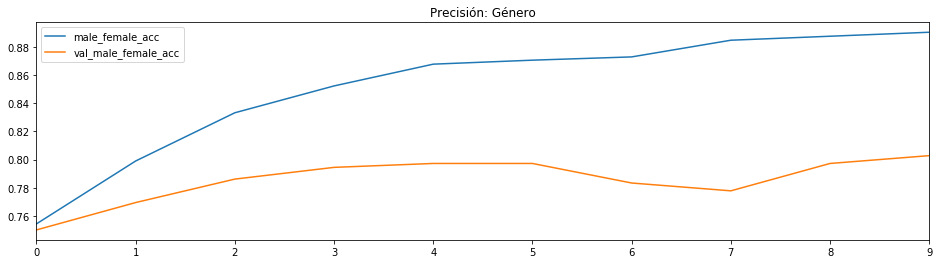

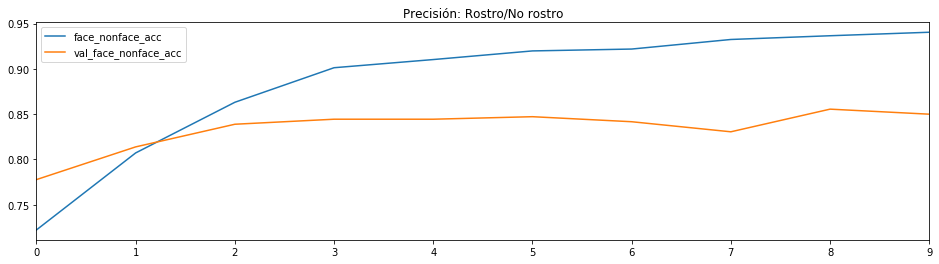

In [6]:
# GENERO ES DE 3 ahora
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.00003/0.9 - sólo 2 cabezas pesos: 1/1
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
# df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

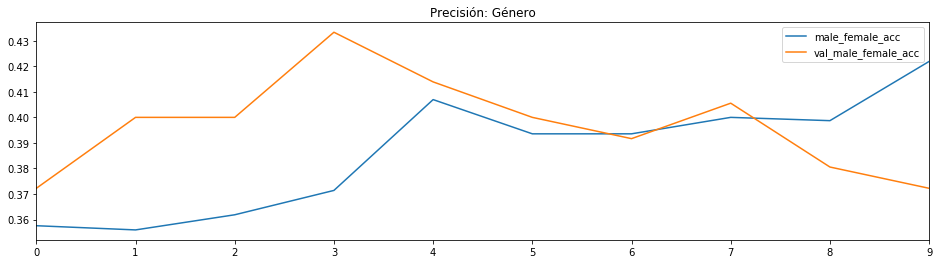

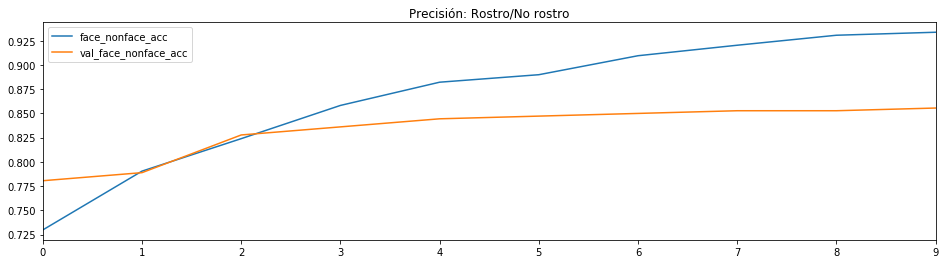

In [9]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.00003/0.9 - sólo 3 cabezas pesos: 1/3/1
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
# df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

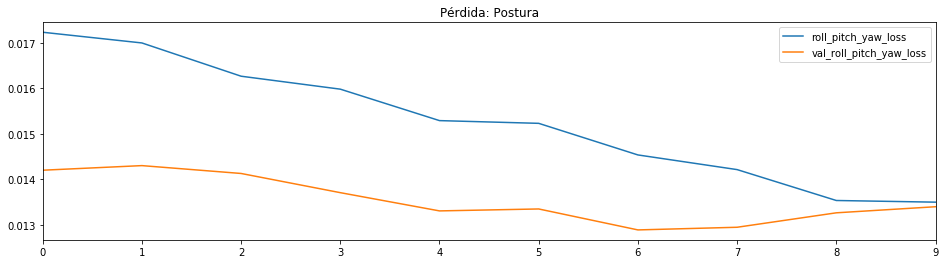

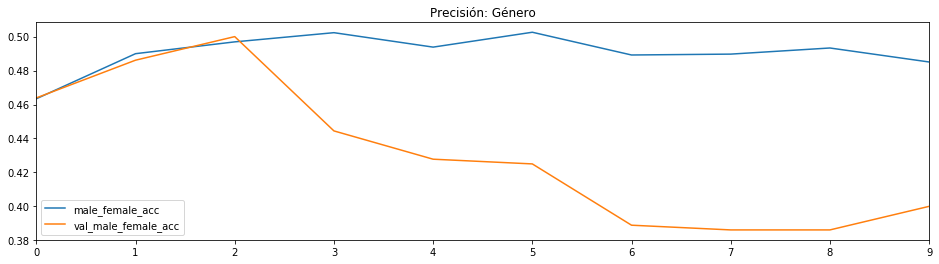

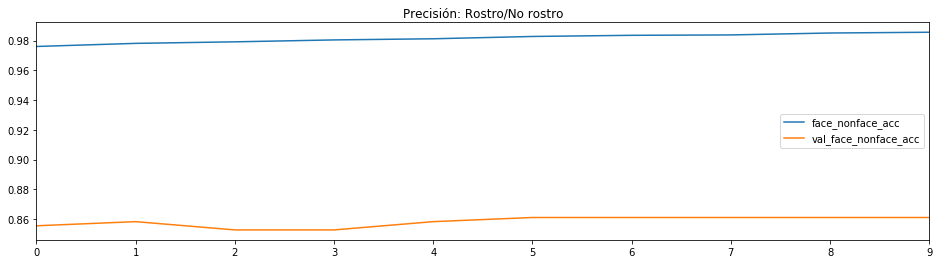

In [14]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.0003/0.9 - sólo 3 cabezas pesos: 1/8/1
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

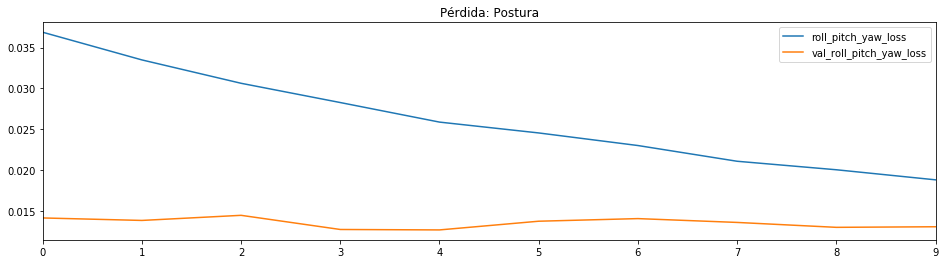

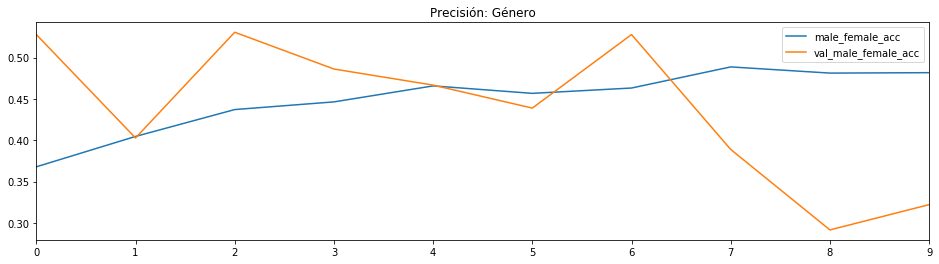

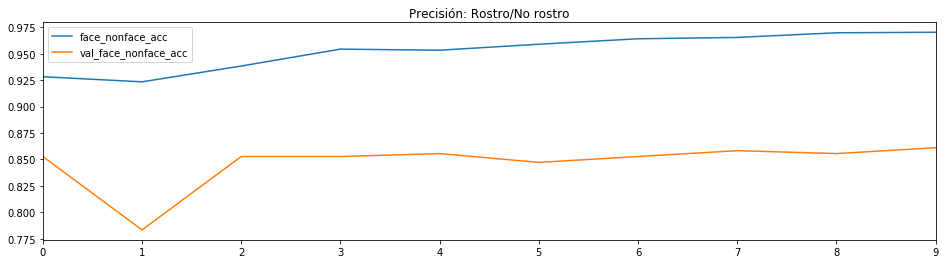

In [12]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.001/0.9 - sólo 3 cabezas pesos: 1/8/1
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

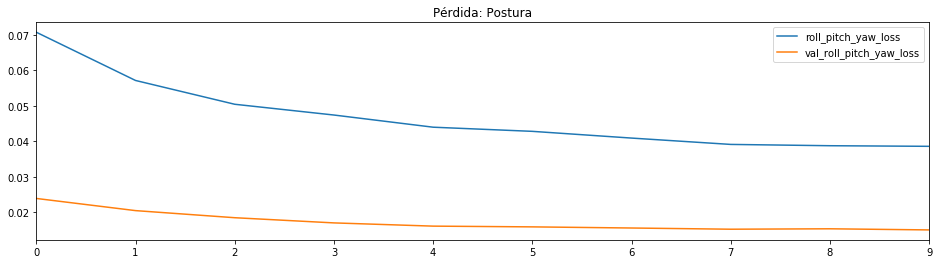

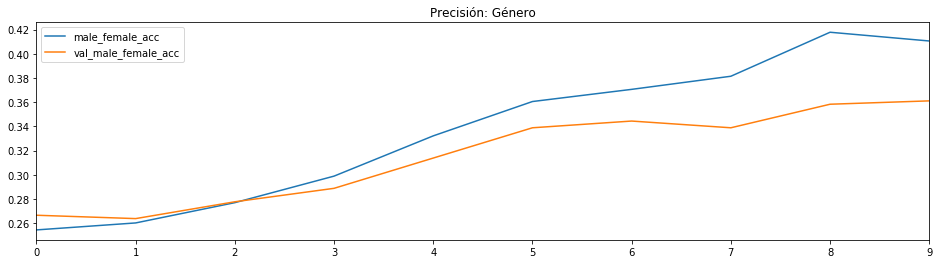

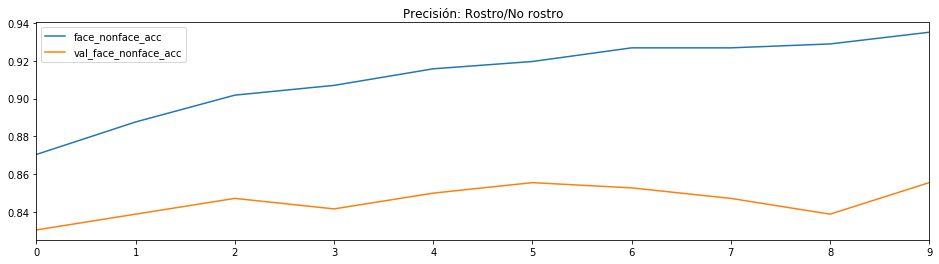

In [10]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.0003/0.9 - sólo 3 cabezas pesos: 1/3/1
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

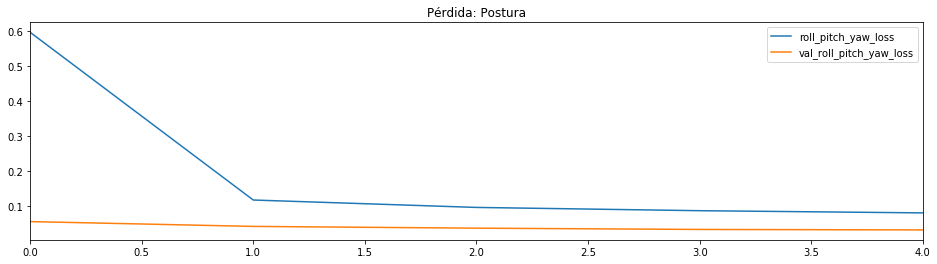

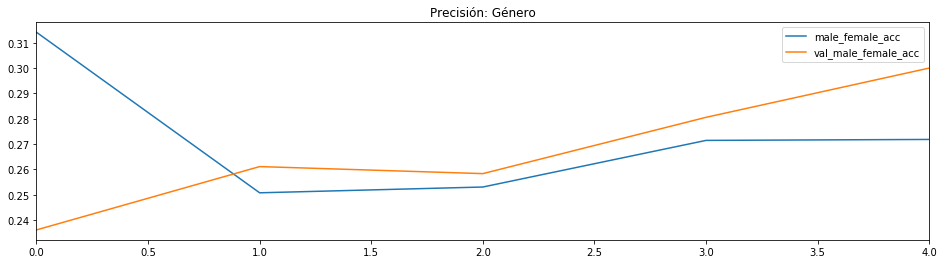

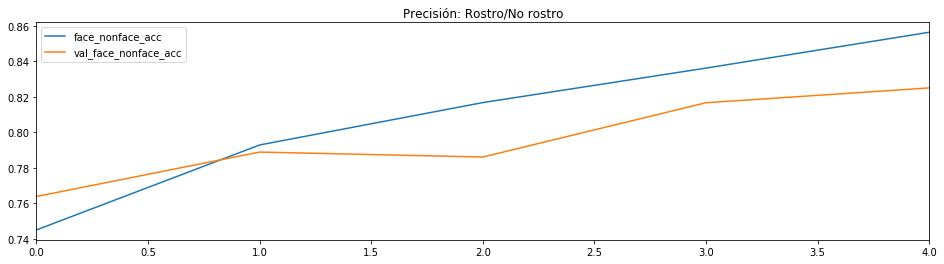

In [8]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.0001/0.9 - sólo 3 cabezas
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
# df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

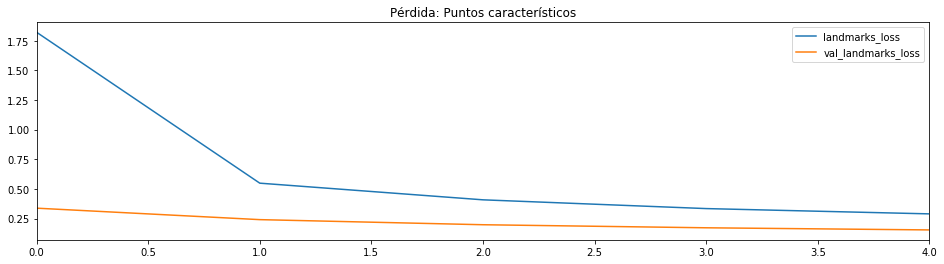

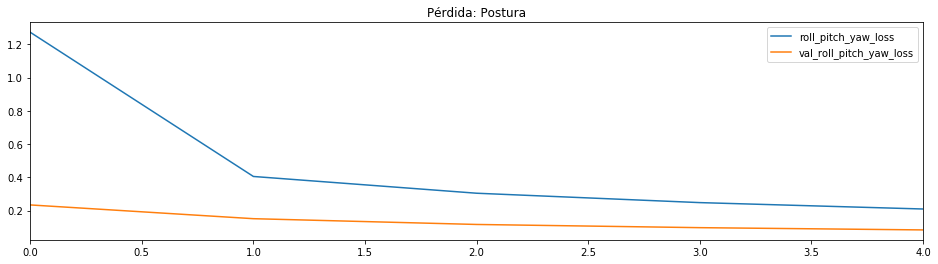

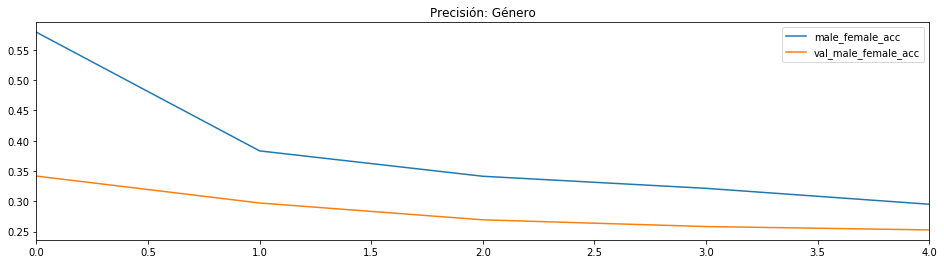

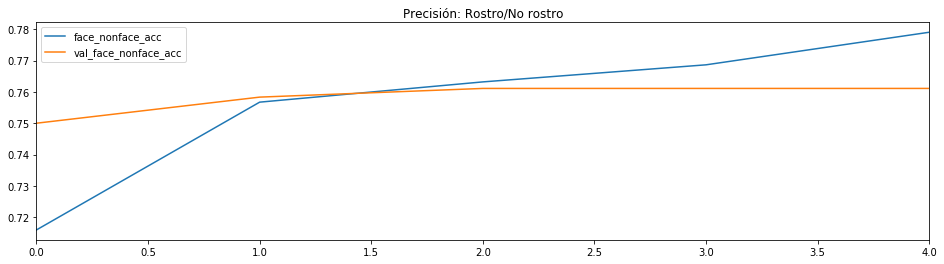

In [8]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.00001/0.9
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

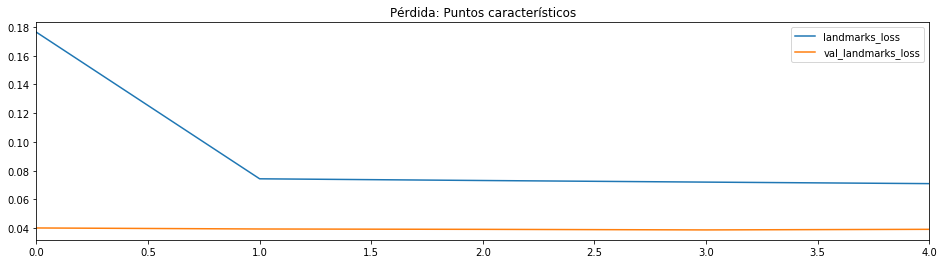

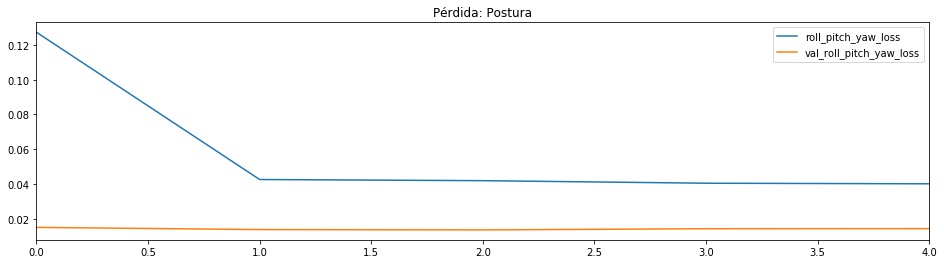

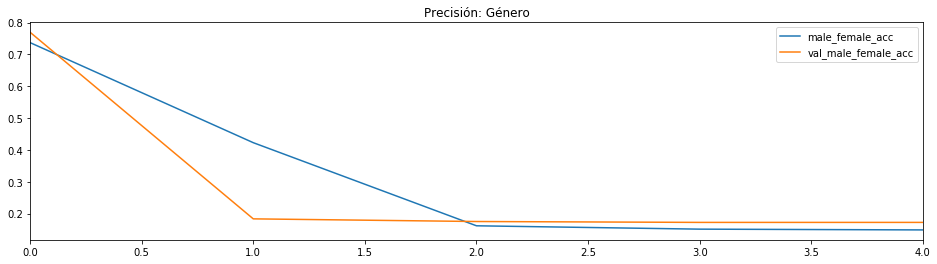

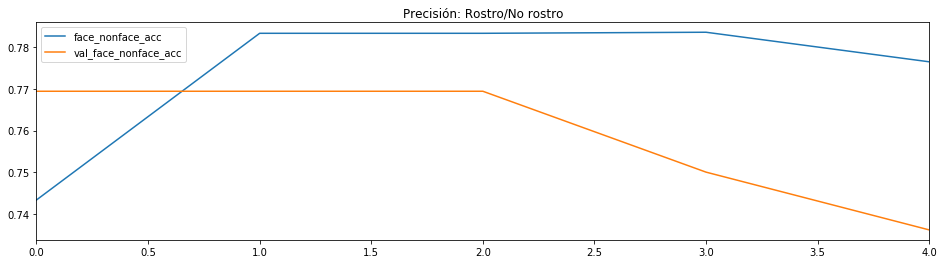

In [26]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - sgd 0.0001/0.9
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

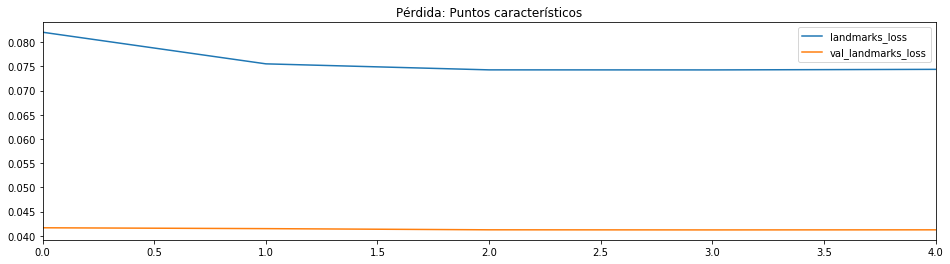

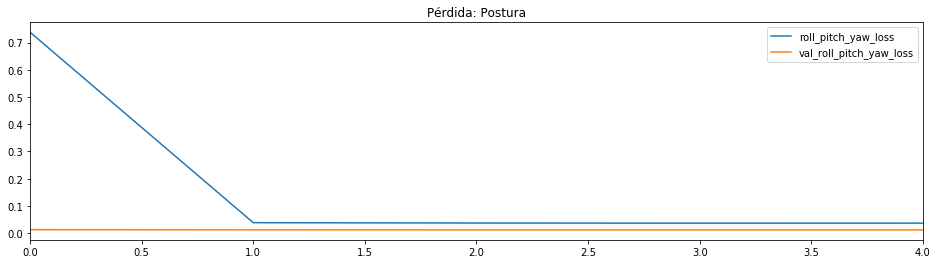

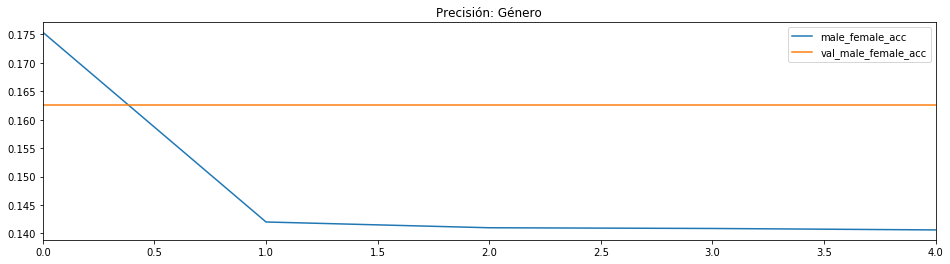

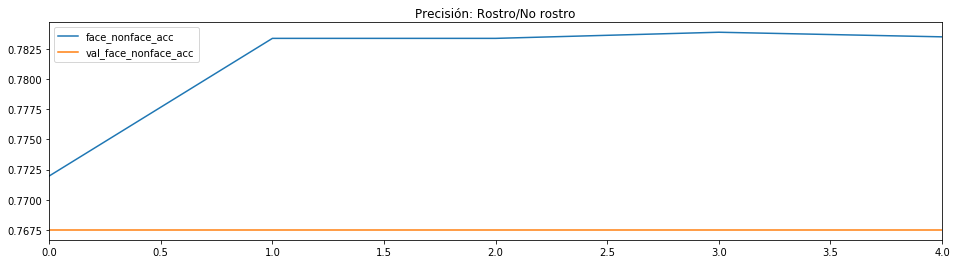

In [34]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - adam 0.01
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

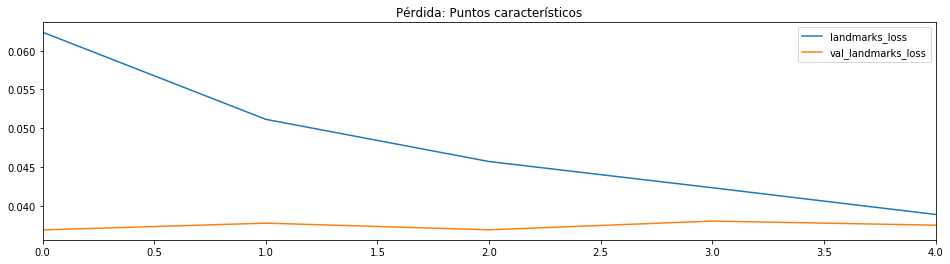

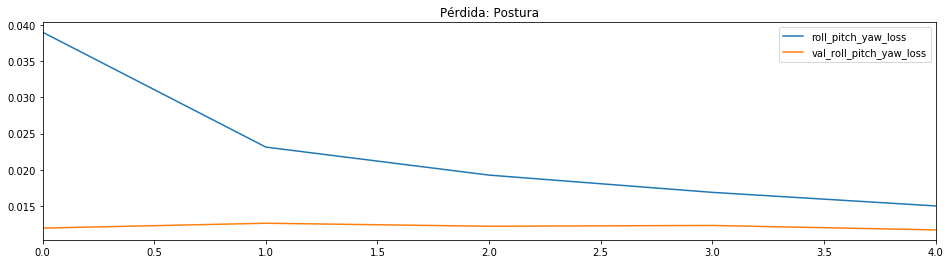

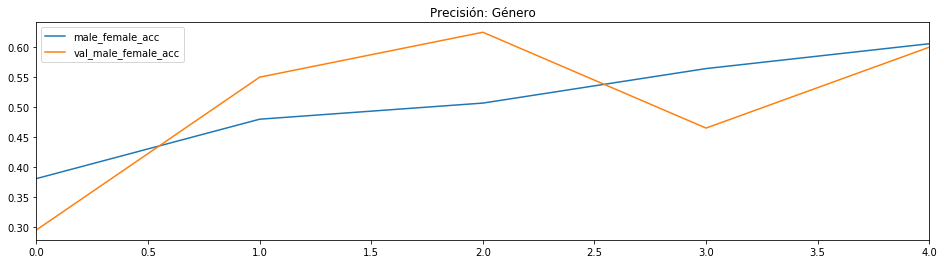

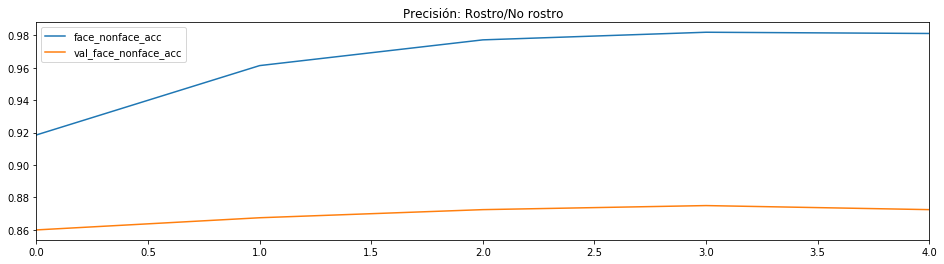

In [27]:
# con hypercaracterísticas: 6x6 - batch: 30/90 - adam 0.001
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

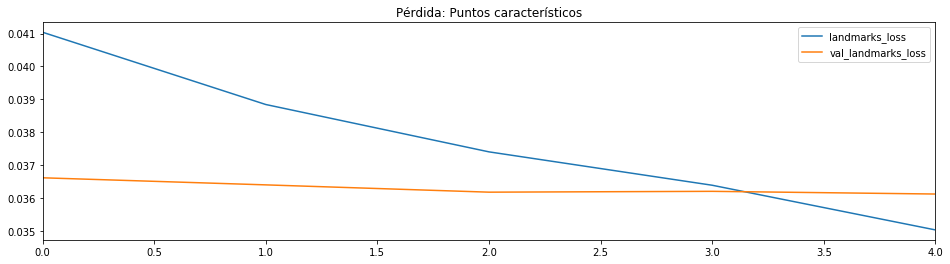

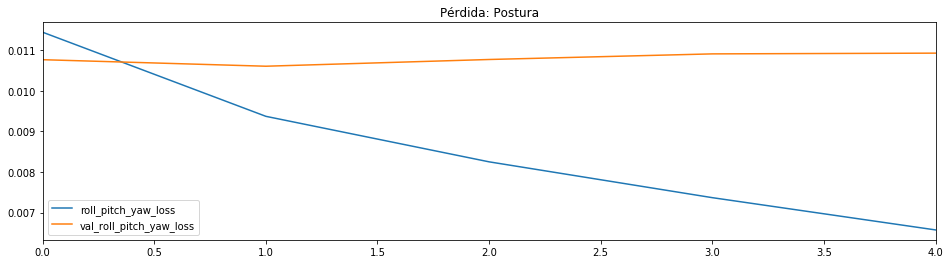

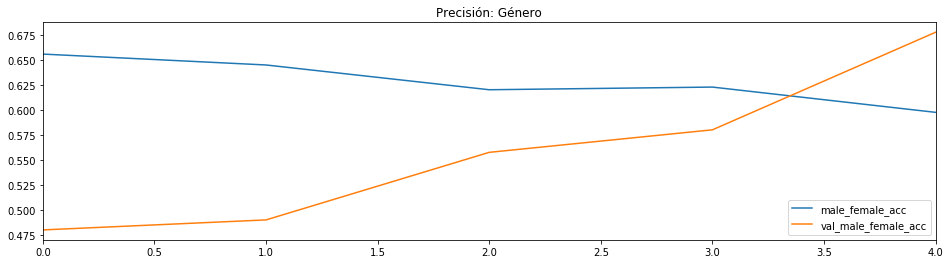

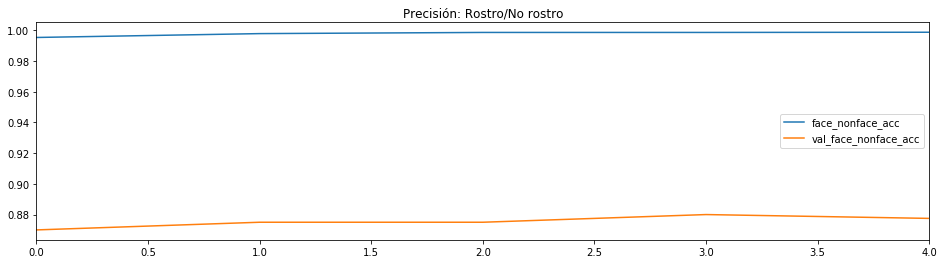

In [23]:
# con hypercaracterísticas: 6x6 - batch: 30/90
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

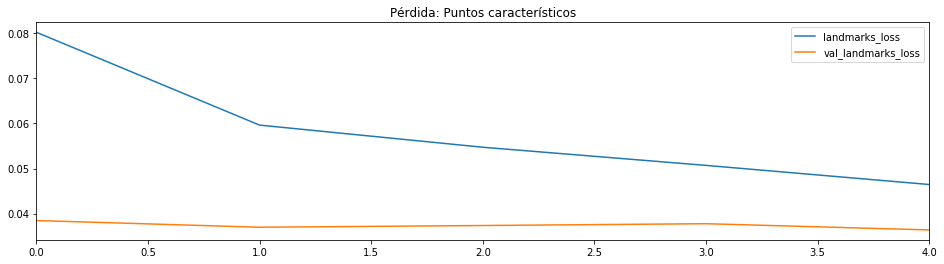

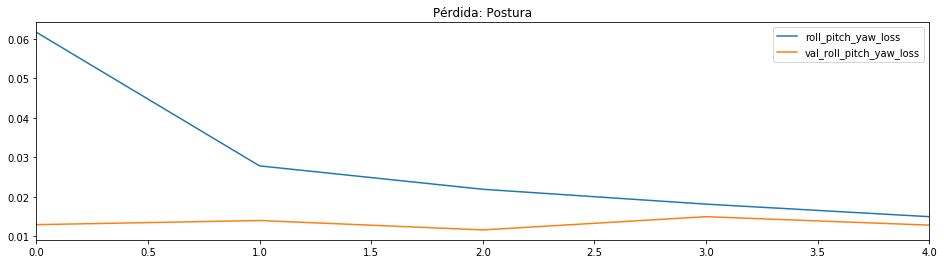

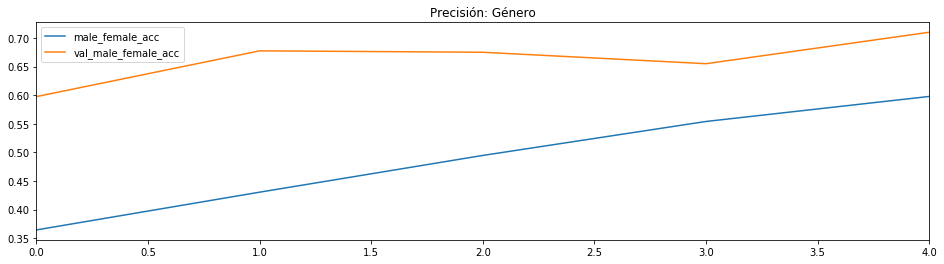

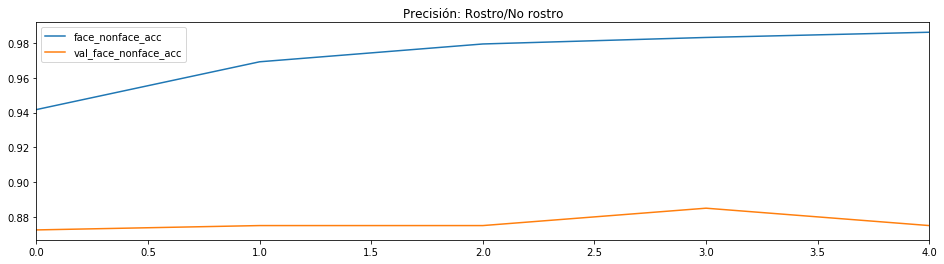

In [20]:
# con hypercaracterísticas: 6x6 - batch: 5/15
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

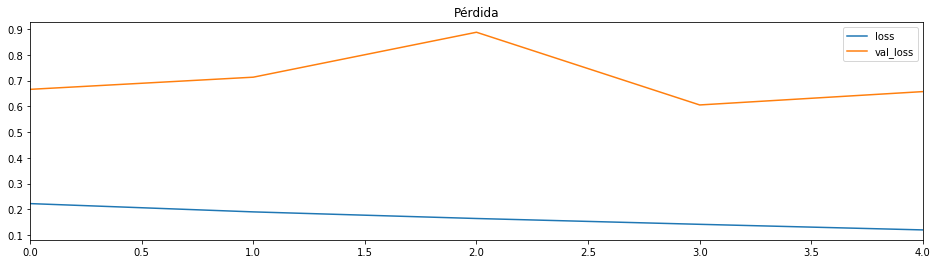

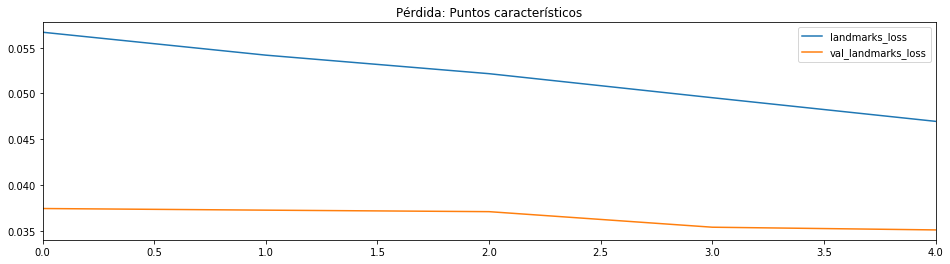

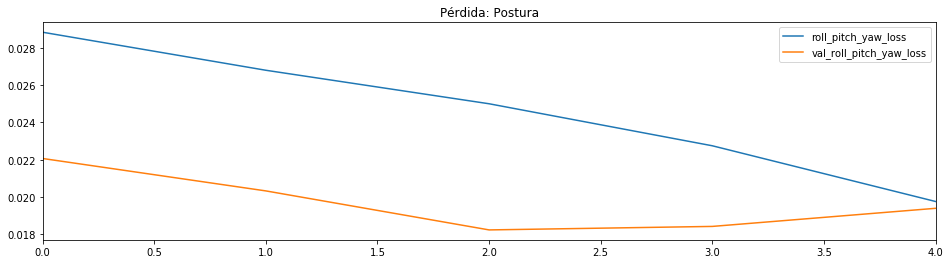

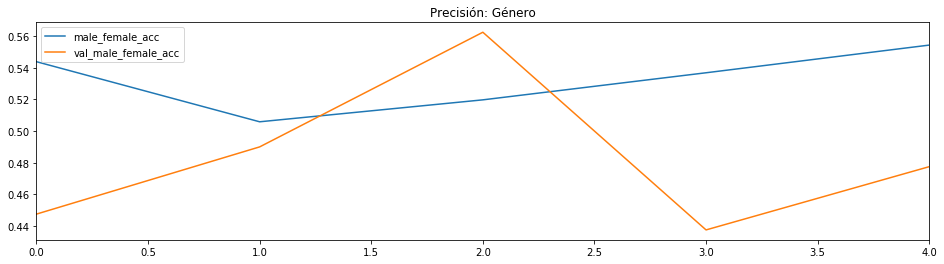

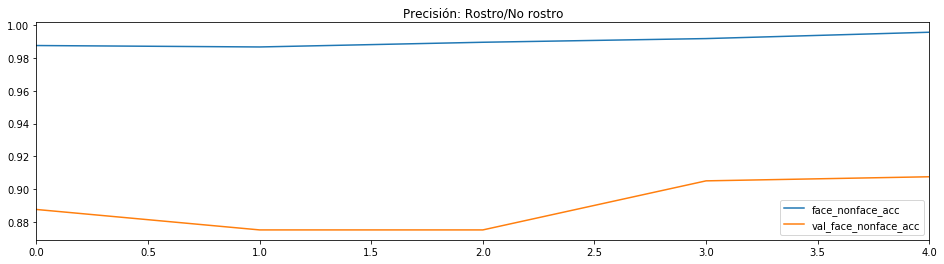

In [13]:
# con hypercaracterísticas: 4x4 - batch: 5/15
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')

#### Cargar modelo y realizar predicciones 
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [10]:
from keras.models import model_from_yaml

model_weights_file = 'hyperface.squeeze.weights.h5'
model_yaml_file = 'hyperface.squeeze.model.yaml'

yaml_file = open(model_yaml_file, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)
loaded_model.load_weights(model_weights_file)
print("Modelo cargado")

# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

data_flow = train_data.flow_from_directory(json_dir,
                                           # 'negatives5k-train.json', 'positives5k-train.json', 
                                           # pos_max_load_labels=12116, neg_max_load_labels=12116*3, #Número de negativos 454512
                                           'positives.json', 'negatives.json', 
                                           pos_max_load_labels=2, neg_max_load_labels=2,
                                           output_type='predict', target_size=(227, 227),
                                           pos_batch_size=64, neg_batch_size=64)
batch_x, batch_image, batch_bbox, batch_y_fnf, batch_y_landmarks, batch_y_visfac, batch_y_pose, batch_y_gender = data_flow.next()

# usar selective search primero, no directamente!
# path = batch_image[0]
# print("loading", path)
# img = image.load_img(path, target_size=(227, 227))
# x = image.img_to_array(img)
# x = train_data.standardize(x)
# x = np.expand_dims(x, axis=0)

subject = 0
x = batch_x[subject]
x = np.expand_dims(x, axis=0)

preds = loaded_model.predict(x)

print('Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)')

print('face_nonface ground truth:')
print(batch_y_fnf[subject])
print('face_nonface predicted:')
print(preds[0])
print()

print('landmarks ground truth:')
print(batch_y_landmarks[subject])
print('landmarks predicted:')
print(preds[1])
print()

print('visibility ground truth:')
print(batch_y_visfac[subject])
print('visibility predicted:')
print(preds[2])
print()

print('pose ground truth:')
print(batch_y_pose[subject])
print('pose predicted:')
print(preds[3])
print()

print('gender ground truth:')
print(batch_y_gender[subject])
print('gender predicted:')
print(preds[4])
print()

Modelo cargado
Found 2 positive samples and 2 negative samples.
Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)
face_nonface ground truth:
[1 0]
face_nonface predicted:
[[ 0.98489952  0.01510049]]

landmarks ground truth:
[-0.2704918  -0.17213115  0.00273224  0.14480874  0.21038251 -1.81693989
 -0.19398907 -0.1010929  -0.05191257 -1.81693989  0.1557377  -1.81693989
 -1.81693989 -0.06830601  0.12295082 -1.81693989 -1.81693989 -0.17213115
  0.00819672 -1.81693989 -0.04644809 -0.3136646  -0.38819876 -0.32608696
 -0.30124224 -0.27639752 -0.59937888 -0.26397516 -0.26397516 -0.23291925
 -0.59937888 -0.18322981 -0.59937888 -0.59937888  0.02795031  0.02173913
 -0.59937888 -0.59937888  0.14596273  0.17080745 -0.59937888  0.44409938]
landmarks predicted:
[[ 0.04401919 -0.14243934 -0.18929863  0.09210169  0.34183574 -0.58608758
  -0.05320793  0.15377617 -0.181765   -0.64482743 -0.4497706  -0.18508683
  -0.7268095   0.36321101 -0.08837103 -0.33759227 -0.45349756 -0